In [1]:
!nvidia-smi

Thu Apr 15 10:19:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install fastbook

     |████████████████████████████████| 727kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 13.5MB/s 
     |████████████████████████████████| 194kB 36.5MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 776.8MB 20kB/s 
     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 12.8MB 167kB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
from fastai.vision.all import *
import gc

In [4]:
gc.collect()
path = untar_data(URLs.IMAGENETTE)

In [5]:
def get_dls(path, size=224, bs = 64):
  dblock = DataBlock(blocks=(ImageBlock,CategoryBlock), 
          get_items = get_image_files,
          get_y = parent_label,
          item_tfms = Resize(size),
          batch_tfms = [#*aug_transforms(min_scale=0.75,size=size), 
                        Normalize.from_stats(*imagenet_stats)] )
  dls = dblock.dataloaders(path, bs=bs)
  return dls

In [6]:
dls = get_dls(path, size = 128, bs = 64)

Check std and mean

In [ ]:
x,y = dls.one_batch()

In [ ]:
x.mean(dim=[0,2,3]), x.std(dim = [0,2,3])

(TensorImage([-0.0342,  0.0340,  0.1059], device='cuda:0'),
 TensorImage([1.2050, 1.2016, 1.3205], device='cuda:0'))

### Testing crop into square for a single image.

In [ ]:
x.shape

torch.Size([64, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


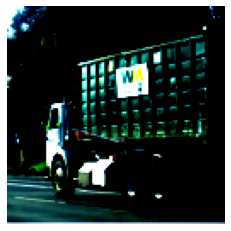

In [ ]:
show_image(x[60])

In [ ]:
image = x[60]
dimension = image.shape[1]
redu50 = int(dimension/2)
image.shape
# first channel is RGB

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


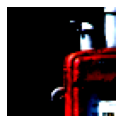

In [ ]:
show_image(image[:,:redu50,:redu50])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


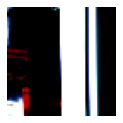

In [ ]:
show_image(image[:,:redu50,redu50:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


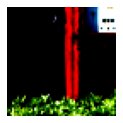

In [ ]:
show_image(image[:,redu50:,:redu50])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


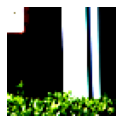

In [ ]:
show_image(image[:,redu50:,redu50:])

In [ ]:
corners = image[:,:redu50,:redu50], image[:,:redu50,redu50:], image[:,redu50:,:redu50], image[:,redu50:,redu50:]

In [ ]:
redu25 = int(dimension/4)
redu75 = int(dimension*3/4)
redu25,redu75

(32, 96)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


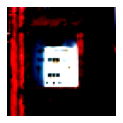

In [ ]:
show_image(image[:,redu25:redu75,redu25:redu75])

In [ ]:
center = image[:,redu25:redu75,redu25:redu75]

### Creating a function that retuns the corners and center

In [ ]:
x = "hello"
#if condition returns False, AssertionError is raised:
assert x == "hello", "x should be 'hello'"

In [ ]:
def get_corners_center(image):
  dimension_x = image.shape[1] # since same dimension
  dimension_y = image.shape[2]
  assert dimension_x == dimension_y, 'dimensions of the image are not equal {}, {}'.format(dimension_x,dimension_y)
  dimension = image.shape[1]
  redu25 = int(dimension/4)
  redu50 = int(dimension/2)
  redu75 = int(dimension*3/4)
  center = image[:,redu25:redu75,redu25:redu75]
  corners = image[:,:redu50,:redu50], image[:,:redu50,redu50:], image[:,redu50:,:redu50], image[:,redu50:,redu50:]
  return corners, center

In [ ]:
corners, center = get_corners_center(image)

### Trying it out: Applying TTA to training set -- not the correct way to do it.

Following the patch structure for augment in [docs](https://github.com/fastai/fastai/blob/ab154927696338741e59e0ffc4774777c4a9781c/fastai/vision/augment.py#L202)

There are different types of tfms LightingTfm, SpaceTfm, AffineCoordTfm, RandTransform, DisplayedTransform etc..

In [7]:
@patch
def TTA_mod(x:TensorImage):
        orig_sz = _get_sz(x)
        w,h = dimension_x, dimension_y = orig_sz
        assert dimension_x == dimension_y, 'dimensions of the image are not equal {}, {}'.format(dimension_x,dimension_y)
        #print(w,h)
        dimension = dimension_x
        redu25 = int(dimension/4)
        redu50 = int(dimension/2)
        redu75 = int(dimension*3/4)
        center = x[:,redu25:redu75,redu25:redu75]
        corners = x[:,:redu50,:redu50], x[:,:redu50,redu50:], x[:,redu50:,:redu50], x[:,redu50:,redu50:]
        tl_corner0 = corners[0]
        tl_corner1 = corners[1]
        tl_corner2 = corners[2]
        tl_corner3 = corners[3]
        tl_center = center
        return tl_center,tl_corner1,tl_corner2,tl_corner3,tl_corner3

In [8]:
def get_dls(path, size=224, bs = 64):
  dblock = DataBlock(blocks=(ImageBlock,CategoryBlock), 
          get_items = get_image_files,
          get_y = parent_label,
          item_tfms = Resize(size),
          batch_tfms = [#*aug_transforms(min_scale=0.75,size=size), 
                        TTA_mod,
                        Normalize.from_stats(*imagenet_stats)] )
  dls = dblock.dataloaders(path, bs=bs)
  return dls

In [9]:
dls = get_dls(path,size =128 , bs =64)

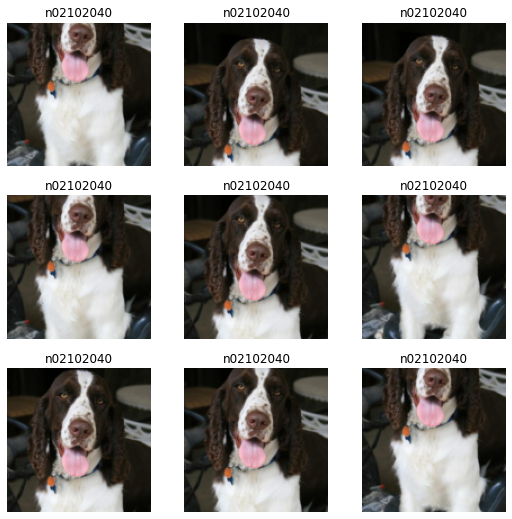

In [16]:
dls.show_batch(max_n=9, unique=True)

In [11]:
model = xresnet34()
loss = CrossEntropyLossFlat()
learn = Learner(dls, model = model, loss_func=loss, metrics=accuracy)

In [12]:
learn.fit_one_cycle(2,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.431943,1.368796,0.547050,01:25
1,0.886071,0.769903,0.753921,01:24


But stupidly this is sort of a random resized crop!

## TTA to only valid set
Trying first with normal dls to setup learner and run for 2 epochs.

In [13]:
def get_dls(path, size=224, bs = 64):
  dblock = DataBlock(blocks=(ImageBlock,CategoryBlock), 
          get_items = get_image_files,
          get_y = parent_label,
          item_tfms = Resize(size),
          batch_tfms = [#*aug_transforms(min_scale=0.75,size=size), 
                        Normalize.from_stats(*imagenet_stats)] )
  dls = dblock.dataloaders(path, bs=bs)
  return dls

dls = get_dls(path,size =128 , bs =64)
model = xresnet34()
loss = CrossEntropyLossFlat()
learn = Learner(dls, model = model, loss_func=loss, metrics=accuracy)
learn.fit_one_cycle(2,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.408412,1.331980,0.572816,01:24
1,0.903981,0.810023,0.747573,01:25


Now, replace the valid set in `dls.valid` with the new set after including the corners and center. 

This will increase the number of validation images as well by 5x.

In [14]:
def get_valid_image(dls,idx,size):
  """
  function to retun the PIL image from validation set and resize to size
  returns the tensor for the resized image
  """
  img = dls.valid_ds[idx][0]
  return image2tensor(img.resize(torch.Size([size,size])))

In [15]:
def get_regions(image):
  """
  function to get the 4 corners and center 
  """
  #image = image2tensor(image)
  r,dimension_x, dimension_y = image.shape
  assert dimension_x == dimension_y, 'dimensions of the image are not equal {}, {}'.format(dimension_x,dimension_y)
  #print(w,h)
  dimension = dimension_x
  redu25 = int(dimension/4)
  redu50 = int(dimension/2)
  redu75 = int(dimension*3/4)
  center = image[:,redu25:redu75,redu25:redu75]
  corners = image[:,:redu50,:redu50], image[:,:redu50,redu50:], image[:,redu50:,:redu50], image[:,redu50:,redu50:]
  tl_corner0 = corners[0]
  tl_corner1 = corners[1]
  tl_corner2 = corners[2]
  tl_corner3 = corners[3]
  tl_center = center
  return tl_center,tl_corner1,tl_corner2,tl_corner3,tl_corner3

In [ ]:
def get_valid_stack(dls,size=128,bs=64):
  """
  function to make the new tensor x and y with all corners and centers so as to 
  call learn.model in GPU.
  """
  valid_size = len(dls.valid_ds)
  # size = 128
  x = [get_valid_image(dls,x,size) for x in range(0,len(dls.valid_ds))]
  y = [dls.valid_ds[x][1] for x in range(0,len(dls.valid_ds))]
  new_x =[]
  new_y = []
  for i in range(0,valid_size):
    tl_center,tl_corner0,tl_corner1,tl_corner2,tl_corner3 = get_regions(x[i])
    new_x.append(tl_center)
    new_x.append(tl_corner0)
    new_x.append(tl_corner1)
    new_x.append(tl_corner2)
    new_x.append(tl_corner3)
    new_y.append(y[i])
    new_y.append(y[i])
    new_y.append(y[i])
    new_y.append(y[i])
    new_y.append(y[i])
  x = torch.stack(new_x).float()#.view(-1,size,size)
  y = torch.stack(new_y).long().unsqueeze(1)
  del new_x, new_y
  gc.collect()
  valid_stack = list(zip(x,y))
  return DataLoader(valid_stack,batch_size=bs)

In [ ]:
#dls.valid = dls_valid_backup

In [ ]:
# dls_valid_backup = dls.valid

In [ ]:
type(dls.valid)

fastai.data.core.TfmdDL

In [ ]:
dls.valid = get_valid_stack(dls,size = 128,bs =64)

In [ ]:
dls.valid

In [ ]:
gc.collect()
#torch.cuda.empty_cache()
type(dls.valid)

fastai.data.load.DataLoader

With the updated `dataloader` for the valid set, train for 10 epochs. 

Compare by doing 12 epochs wihout this manual tta.

In [ ]:
learn.fit_one_cycle(10,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.500627,188.055801,0.097760,01:07
1,0.643604,151.991562,0.101942,01:07
2,0.616509,164.809021,0.107767,01:07
3,0.512862,215.341095,0.110232,01:07
4,0.422689,237.935211,0.106049,01:07
5,0.339680,146.117538,0.132487,01:07
6,0.224391,386.696381,0.095519,01:08
7,0.142008,240.366379,0.120314,01:07
8,0.088487,299.946259,0.102838,01:07
9,0.070522,309.740509,0.102240,01:07


As someone commented in the forums, the TTA loss exploded. [see here](https://forums.fast.ai/t/chapter-7-further-research-implementing-tta/76184)

But mine is a bad implementation. It doesn not take the average of the preds for each image. Need to do better as the example given above.

### With fastai TTA

In [ ]:
def get_dls(path, size=224, bs = 64):
  dblock = DataBlock(blocks=(ImageBlock,CategoryBlock), 
          get_items = get_image_files,
          get_y = parent_label,
          item_tfms = Resize(size),
          batch_tfms = [#*aug_transforms(min_scale=0.75,size=size), 
                        Normalize.from_stats(*imagenet_stats)] )
  dls = dblock.dataloaders(path, bs=bs)
  return dls

In [ ]:
dls = get_dls(path,size = 128, bs =64)
x,y = dls.one_batch()

In [ ]:
type(x),type(y)

(fastai.torch_core.TensorImage, fastai.torch_core.TensorCategory)

In [ ]:
model = xresnet34()
loss = CrossEntropyLossFlat()
learn = Learner(dls, model = model, loss_func=loss, metrics=accuracy)
learn.fit_one_cycle(2,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.384815,2.055215,0.473114,01:43
1,0.854001,0.795118,0.747573,01:42


In [ ]:
preds,targs = learn.tta(n=10)

In [ ]:
learn.loss_func(preds,targs).item(), accuracy(preds,targs).item()

(6.2899909019470215, 0.74607914686203)